## This notebook implements the GuidedNet method on the University of Houston RGB and Hyperspectral images

Imports

In [1]:
import numpy as np
import scipy.io as sio
import time
import random
import cv2
import math
import pynvml

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import io as iot
import sys
from spectral import *
from tqdm import trange
from argparse import Namespace
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.special import gamma, kv, erf
from config import *
from collections import OrderedDict
from tqdm import tqdm
import psutil
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [2]:
def set_random_seed(seed=42):
    """
    Sets the random seed for reproducibility in TensorFlow, NumPy, and Python.
    Also sets TF deterministic ops.
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Optional: Force deterministic operations
    try:
        tf.config.experimental.enable_op_determinism()
    except AttributeError:
        # Older TF version fallback
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        
set_random_seed(42)

Helper Functions

In [3]:
def numpy_to_tf(image):
    
    """
    Converts a numpy array into a tensorflow tensor.
    
    Parameters:
    -----------
    image : np.ndarray
        Shape (height, width, channels)
        
     Returns:
    --------
    image_tf: tf.constant
        Shape (1, height, width, channels
    """
    
    image = np.expand_dims(image, axis=0)
    image_tf = tf.constant(image, dtype=tf.float32)
    
    return image_tf

def tf_to_numpy(image_tf):
    
    """
    Converts a tensorflow tensor into a numpy array.
    
    Parameters:
    -----------
    image_tf : tf.constant
        Shape (1, height, width, channels)
        
     Returns:
    --------
    image: np.ndarray
        Shape (height, width, channels
    """
    
    image = image_tf.numpy()
    image = np.squeeze(image)
    
    return image

In [4]:
# Defining the Gaussian PSF for synthetic data generation

kernel_size = 7
sigma = 3.40

def gaussian_psf(sigma, psf_size):
    """Generate a Gaussian PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf = psf / psf.sum()
    return psf
gaus_psf = gaussian_psf(sigma, kernel_size)

In [5]:
# Function to apply PSF to an image
def apply_psf(image, psf):
    
    """
    Convolve each channel of 'image' with 'psf' using 'same' padding.

    Parameters:
    -----------
    image : np.ndarray
        Shape (height, width, channels).
    psf   : np.ndarray
        Shape (kernel_height, kernel_width).
        
    Returns:
    --------
    blurred_image : np.ndarray
        Same shape as input image (height, width, channels).
    """
    
    # Prepare an output array of the same shape as 'image'
    blurred_image = np.zeros_like(image, dtype=np.float32)

    # Convolve each channel separately
    channels = image.shape[2]
    for c in range(channels):
        # convolve2d with mode='same' replicates TensorFlow's 'SAME' padding
        blurred_image[:, :, c] = convolve2d(image[:, :, c], psf, mode='same')
        
    return blurred_image
    
# Function to downsample an image
def downsample_image(image, factor):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Initialize a list to hold the downsampled channels
    downsampled_channels = []
    
    # Downsample each channel individually
    for c in range(channels):
        channel = image[:, :, c]
        downsampled_channel = cv2.resize(channel, (width // factor, height // factor), interpolation=cv2.INTER_AREA)
        downsampled_channels.append(downsampled_channel)
    
    # Stack the downsampled channels back together
    downsampled_image = np.stack(downsampled_channels, axis=-1)
    
    return downsampled_image
    
# Function to add noise to an image
def add_awgn_noise(hsi_image, SNR_dB):
    
    """
    Add AWGN (Additive White Gaussian Noise) to the input hsi_image,
    given a desired SNR in dB. Uses NumPy only.

    Parameters
    ----------
    hsi_image : np.ndarray
        Input image of shape (rows, cols, channels).
    SNR_dB : float
        Desired SNR in decibels.

    Returns
    -------
    noisy_hsi_image : np.ndarray
        Noisy image of the same shape as hsi_image.
    """

     # Ensure float32
    hsi_image = hsi_image.astype(np.float32)

    rows, cols, channels = hsi_image.shape

    # Compute the signal power for each channel
    # shape: (channels,)
    signal_power = np.mean(hsi_image ** 2, axis=(0, 1))

    # Convert SNR from dB to linear scale
    SNR_linear = 10 ** (SNR_dB / 10.0)

    # Compute noise power and noise standard deviation per channel
    noise_power = signal_power / SNR_linear  # shape: (channels,)
    noise_std = np.sqrt(noise_power)         # shape: (channels,)

    # Reshape for broadcasting across (rows, cols)
    noise_std = noise_std.reshape((1, 1, channels))

    # Generate white Gaussian noise
    noise = np.random.normal(
        loc=0.0, 
        scale=1.0, 
        size=(rows, cols, channels)
    ).astype(np.float32)

    # Scale noise by the computed standard deviation
    noise *= noise_std

    # Add noise to the original image
    noisy_hsi_image = hsi_image + noise

    return noisy_hsi_image
    
# Function to normalize an image between 0 and 1 safely
def normalize(image):
    """
    Normalize an image to the range [0, 1] while clipping outliers.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image with arbitrary range values.
    
    Returns:
    --------
    normalized_image : np.ndarray
        Normalized image in range [0, 1].
    """
    min_val, max_val = np.percentile(image, [1, 99])
    return (np.clip(image, min_val, max_val) - min_val) / (max_val - min_val)

# Function to obtain the Spectral Response Function for spectral degradation
def get_srf_bands(num_bands: int) -> np.ndarray:
    """
    Return a (num_bands, 3) array of [center_nm, low_edge_nm, high_edge_nm]
    matching the specified 'num_bands' from {1,3,4,8,16}.
    
    1-band  => IKONOS Panchromatic
    3-bands => IKONOS RGB
    4-bands => IKONOS B, G, R, NIR
    8-bands => WorldView-2 
    16-bands => WorldView-3

    Raises ValueError if num_bands is not in [1,3,4,8,16].
    """

    if num_bands == 1:
        # IKONOS panchromatic
        band_specs = np.array([
            [729.0, 409.0, 1048.0]  # center, lower, upper
        ], dtype=np.float32)
    
    elif num_bands == 3:
        # IKONOS RGB
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
        ], dtype=np.float32)
    
    elif num_bands == 4:
        # IKONOS B, G, R, NIR
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
            [803.0, 713.0, 893.0],  # NIR
        ], dtype=np.float32)

    elif num_bands == 8:
        # WorldView-2
        band_specs = np.array([
            [427.0, 396.0, 458.0],  # Coastal Blue
            [478.0, 442.0, 515.0],  # Blue
            [546.0, 506.0, 586.0],  # Green
            [608.0, 584.0, 632.0],  # Yellow
            [659.0, 624.0, 694.0],  # Red
            [724.0, 699.0, 749.0],  # Red Edge
            [833.0, 765.0, 901.0],  # NIR1
            [949.0, 856.0, 1043.0], # NIR2
        ], dtype=np.float32)
    
    elif num_bands == 16:
        # WorldView-3
        band_specs = np.array([
            [426.0, 397.0, 454.0],    # Coastal Blue
            [481.0, 445.0, 517.0],    # Blue
            [547.0, 507.0, 586.0],    # Green
            [605.0, 580.0, 629.0],    # Yellow
            [661.0, 626.0, 696.0],    # Red
            [724.0, 698.0, 749.0],    # Red Edge
            [832.0, 765.0, 899.0],    # NIR1
            [948.0, 857.0, 1039.0],   # NIR2
            [1210.0, 1184.0, 1235.0], # SWIR1
            [1572.0, 1546.0, 1598.0], # SWIR2
            [1661.0, 1636.0, 1686.0], # SWIR3
            [1730.0, 1702.0, 1759.0], # SWIR4
            [2164.0, 2137.0, 2191.0], # SWIR5
            [2203.0, 2174.0, 2232.0], # SWIR6
            [2260.0, 2228.0, 2292.0], # SWIR7
            [2329.0, 2285.0, 2373.0], # SWIR8
        ], dtype=np.float32)
    
    else:
        raise ValueError(f"Unsupported num_bands={num_bands}. Must be 1,3,4,8, or 16.")

    return band_specs
    
# Function to apply SRF to an image
def apply_srf(
    hyper_image: np.ndarray,
    band_specs: np.ndarray,
    fwhm_factor: float = 4.2
):
    """
    Apply a Gaussian-based SRF (based on band_specs) to the given HR hyperspectral image.
    
    Unlike the previous version, this function infers the number of HSI bands (L) 
    from hyper_image.shape, and automatically constructs a linearly-spaced 
    wavelength array from the minimum lower_edge to the maximum upper_edge 
    in band_specs.

    Parameters
    ----------
    hyper_image : np.ndarray
        (rows, cols, L) float32 (or will be converted). The high-resolution HSI.
    band_specs : np.ndarray
        (num_bands, 3) array, each row = [center_nm, low_edge_nm, upper_edge_nm].
        Examples: 
            - 1-band IKONOS Panchromatic 
            - 3-band IKONOS RGB 
            - 4-band IKONOS (B,G,R,NIR) 
            - 8-band WorldView-2 
            - 16-band WorldView-3
        etc.
    fwhm_factor : float
        Factor to convert from (upper_edge - lower_edge) to approximate standard deviation.
        By default 4.2, typical ratio (FWHM / (2.355...) or so for a Gaussian).

    Returns
    -------
    ms_image : np.ndarray
        (rows, cols, num_bands). The resulting multi/pan/RGB image.
    srf : np.ndarray
        (num_bands, L). The spectral response function for each output band
        across the L inferred HSI wavelength positions.
    auto_wavelengths : np.ndarray
        (L,) The automatically-generated wavelength array spanning 
        [min_lower_edge, max_upper_edge].
    """

    # 1) Ensure float32
    hyper_image = hyper_image.astype(np.float32)
    rows, cols, L = hyper_image.shape

    # 2) Determine the min/max edges from band_specs
    #    We will assume the entire HSI covers this range uniformly.
    #    E.g. for IKONOS Panchromatic: [409, 1048], etc.
    min_lower_edge = band_specs[:, 1].min()
    max_upper_edge = band_specs[:, 2].max()

    # 3) Construct a linearly-spaced wavelength array of length L
    #    from min_lower_edge to max_upper_edge, inclusive
    auto_wavelengths = np.linspace(min_lower_edge, max_upper_edge, L).astype(np.float32)
    # Shape: (L,)  We'll reshape to (1, L) for broadcasting
    wave_2d = auto_wavelengths[None, :]  # shape => (1, L)

    # 4) Prepare the SRF array
    num_bands = band_specs.shape[0]
    srf = np.zeros((num_bands, L), dtype=np.float32)

    for i in range(num_bands):
        center_nm = band_specs[i, 0]
        low_nm    = band_specs[i, 1]
        high_nm   = band_specs[i, 2]

        # approximate standard deviation from (high - low) / fwhm_factor
        std_nm = (high_nm - low_nm) / fwhm_factor

        # Gaussian SRF across all L wavelengths
        # shape => (1, L); after the operation => (L,) effectively
        srf_i = np.exp(-0.5 * ((wave_2d - center_nm) / std_nm) ** 2)

        # Normalize so the sum of srf_i is 1 across the L channels
        sum_i = srf_i.sum()
        if sum_i > 1e-8:
            srf_i /= sum_i

        srf[i, :] = srf_i

    # 5) Now srf has shape (num_bands, L). We want to apply it to hyper_image:
    #    hyper_image: (rows, cols, L)
    #    srf^T: (L, num_bands)
    # => tensordot => (rows, cols, num_bands)
    srf_t = srf.T  # shape => (L, num_bands)
    ms_image = np.tensordot(hyper_image, srf_t, axes=([2], [0]))  # => (rows, cols, num_bands)

    # 6) Convert to float32
    ms_image = ms_image.astype(np.float32)

    return ms_image, srf, auto_wavelengths

Functions to visualize the inputs

In [6]:
# Function to visualize an HSI
def visualize_hsi(img1, img2, bands, title1, title2):
    """
    Visualize two hyperspectral images side by side using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    img2 : np.ndarray
        Second hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation (applied to both images).
    title1 : str
        Title for the first image.
    title2 : str
        Title for the second image.
    """
    rgb1 = get_rgb(img1, bands)
    rgb2 = get_rgb(img2, bands)

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    axs[0].imshow(rgb1)
    axs[0].set_title(title1)
    axs[0].axis('on')

    axs[1].imshow(rgb2)
    axs[1].set_title(title2)
    axs[1].axis('on')

    plt.tight_layout()
    plt.show()

In [7]:
# Function to visualize an HSI
def visualize_hsi_single(img1, bands, title1):
    """
    Visualize a hyperspectral image using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation
    title1 : str
        Title for the first image.
    """
    rgb1 = get_rgb(img1, bands)

    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.imshow(rgb1)
    ax.set_title(title1)
    ax.axis('on')

    plt.tight_layout()
    plt.show()
    
# Function to visualize an MSI/RGB/Panchromatic image along with the SRF
def plot_multispectral_with_srf(ms_image, bands, title, srf, wavelengths, ikonos_bands):
    """
    Visualize a multispectral (or RGB/panchromatic) image alongside its Spectral Response Function (SRF).
    
    Parameters
    ----------
    ms_image : np.ndarray
        Multispectral image, shape: (rows, cols, num_bands).
    bands : tuple
        Band indices to use for RGB representation (only used if num_bands >= 3).
    title : str
        Title for the image plot.
    srf : np.ndarray
        Spectral Response Function, shape: (num_bands, L).
    wavelengths : np.ndarray
        Wavelengths corresponding to the L hyperspectral bands (x-axis for SRF).
    ikonos_bands : np.ndarray
        An array with shape (num_bands, 3) containing [center_nm, low_edge_nm, high_edge_nm]
        for each band. It is used here just to show the center wavelength in the legend.
    
    Notes
    -----
    - This function assumes num_bands is one of {1,3,4,8,16}.
    - If num_bands=1, we skip get_rgb and just display a grayscale single-band image.
    - If num_bands=3,4,8,16, we attempt to display an RGB image using 'bands' for the channel ordering.
    - The SRF curve colors and labels are chosen via if/elif blocks, 
      matching each possible number of bands.
    """
    num_bands = ms_image.shape[2]  # e.g. 1,3,4,8,16

    # 1) Choose band labels & colors depending on how many bands we have
    if num_bands == 1:
        band_labels = ["Panchromatic"]
        band_colors = ["k"]
    elif num_bands == 3:
        band_labels = ["Blue", "Green", "Red"]
        band_colors = ["b", "g", "r"]
    elif num_bands == 4:
        band_labels = ["Blue", "Green", "Red", "NIR"]
        band_colors = ["b", "g", "r", "k"]
    elif num_bands == 8:
        band_labels = ["Coastal", "Blue", "Green", "Yellow", 
                       "Red", "Red Edge", "NIR1", "NIR2"]
        # You can pick any 8 distinct colors you like:
        band_colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]
    elif num_bands == 16:
        band_labels = [
            "Coastal Blue", "Blue", "Green", "Yellow", 
            "Red", "Red Edge", "NIR1", "NIR2",
            "SWIR1", "SWIR2", "SWIR3", "SWIR4",
            "SWIR5", "SWIR6", "SWIR7", "SWIR8"
        ]
        # Again, pick any 16 distinct colors you like:
        band_colors = [
            "b", "g", "r", "c", "m", "y", "k", "orange", 
            "purple", "brown", "pink", "gray", 
            "olive", "navy", "teal", "maroon"
        ]
    else:
        raise ValueError("Function only supports images with 1, 3, 4, 8, or 16 bands.")
    
    # 2) Create the figure with 2 subplots (image on the left, SRF on the right)
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # 3) Plot the image
    if num_bands == 1:
        # Just display the single-band image in grayscale
        single_band_2d = ms_image[:, :, 0]  # shape (rows, cols)
        axs[0].imshow(single_band_2d, cmap="gray")
        axs[0].set_title(title + " (Single-Band/Panchromatic)")
    else:
        # We have at least 3 bands, so let's form an RGB image
        img_rgb = get_rgb(ms_image, bands)
        axs[0].imshow(img_rgb)
        axs[0].set_title(title)
    axs[0].axis('off')
    
    # 4) Plot the SRF curves in the second subplot
    for i in range(num_bands):
        center_nm = ikonos_bands[i, 0]  # The 'center' column from your band_specs
        axs[1].plot(
            wavelengths,
            srf[i, :],
            label=f'{band_labels[i]} (Center: {center_nm} nm)',
            color=band_colors[i]
        )
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Spectral Response')
    axs[1].set_title('Spectral Response Functions (SRF)')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

Importing the University of Houston images

In [8]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Real_world_Fusion_based_HSI_Super_Resolution_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
hsi_1_file_path = os.path.join(normalized_dataset_path, 'hsi_1.mat')
hsi_2_file_path = os.path.join(normalized_dataset_path, 'hsi_2.mat')
rgb_1_file_path = os.path.join(normalized_dataset_path, 'rgb_image_1.tif')
rgb_2_file_path = os.path.join(normalized_dataset_path, 'rgb_image_2.tif')

In [9]:
def extract_aligned_patches(lr_hsi, hr_rgb, hsi_center_y, hsi_center_x,
                            hsi_patch_size=64, rgb_scale_factor=20, rgb_downsampled_size=512):
    """
    Extract a 64x64 patch from the LR HSI centered at (hsi_center_y, hsi_center_x),
    and the corresponding 1280x1280 patch from the HR RGB image centered at the
    scaled coordinates. Then downsample the RGB patch to 512x512.

    Parameters:
    -----------
    lr_hsi : np.ndarray
        Low-resolution HSI image of shape (H_lr, W_lr, C_hsi).
    hr_rgb : np.ndarray
        High-resolution RGB image of shape (H_hr, W_hr, 3).
    hsi_center_y : int
        Y-coordinate of the HSI patch center.
    hsi_center_x : int
        X-coordinate of the HSI patch center.
    hsi_patch_size : int
        Patch size for the HSI (default: 64).
    rgb_scale_factor : int
        Scaling factor between HSI and RGB resolutions (default: 20).
    rgb_downsampled_size : int
        Final size of the RGB patch after downsampling (default: 512).

    Returns:
    --------
    hsi_patch : np.ndarray
        Extracted HSI patch of shape (hsi_patch_size, hsi_patch_size, C_hsi).
    rgb_patch_downsampled : np.ndarray
        Downsampled RGB patch of shape (rgb_downsampled_size, rgb_downsampled_size, 3).
    """
    
    # --- HSI patch extraction ---
    half_hsi = hsi_patch_size // 2
    hsi_top = hsi_center_y - half_hsi
    hsi_left = hsi_center_x - half_hsi

    if (hsi_top < 0 or hsi_left < 0 or 
        hsi_top + hsi_patch_size > lr_hsi.shape[0] or 
        hsi_left + hsi_patch_size > lr_hsi.shape[1]):
        raise ValueError("HSI patch goes out of bounds.")

    hsi_patch = lr_hsi[
        hsi_top : hsi_top + hsi_patch_size,
        hsi_left : hsi_left + hsi_patch_size,
        :
    ]

    # --- RGB patch extraction ---
    rgb_patch_size = hsi_patch_size * rgb_scale_factor
    half_rgb = rgb_patch_size // 2
    rgb_center_y = hsi_center_y * rgb_scale_factor
    rgb_center_x = hsi_center_x * rgb_scale_factor
    rgb_top = rgb_center_y - half_rgb
    rgb_left = rgb_center_x - half_rgb

    if (rgb_top < 0 or rgb_left < 0 or 
        rgb_top + rgb_patch_size > hr_rgb.shape[0] or 
        rgb_left + rgb_patch_size > hr_rgb.shape[1]):
        raise ValueError("RGB patch goes out of bounds.")

    rgb_patch = hr_rgb[
        rgb_top : rgb_top + rgb_patch_size,
        rgb_left : rgb_left + rgb_patch_size,
        :
    ]

    # --- Downsample the RGB patch ---
    rgb_patch_downsampled = cv2.resize(
        rgb_patch,
        (rgb_downsampled_size, rgb_downsampled_size),
        interpolation=cv2.INTER_AREA
    )

    return hsi_patch, rgb_patch_downsampled

In [10]:
hsi_1 = sio.loadmat(hsi_1_file_path)
hsi_1_image = hsi_1['topLeft']

# Load image
RGB_1 = cv2.imread(rgb_1_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_1_image = np.array(RGB_1)

hsi_patch_1, rgb_patch_1 = extract_aligned_patches(
    lr_hsi=hsi_1_image,
    hr_rgb=RGB_1_image,
    hsi_center_y=400,
    hsi_center_x=450
)

hsi_1_test = normalize(hsi_patch_1)
RGB_1_test = normalize(rgb_patch_1)

In [11]:
hsi_2 = sio.loadmat(hsi_2_file_path)
hsi_2_image = hsi_2['bottomRight']

# Load image
RGB_2 = cv2.imread(rgb_2_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_2_image = np.array(RGB_2)

hsi_patch_2, rgb_patch_2 = extract_aligned_patches(
    lr_hsi=hsi_2_image,
    hr_rgb=RGB_2_image,
    hsi_center_y=400,
    hsi_center_x=400
)

hsi_2_test = normalize(hsi_patch_2)
RGB_2_test = normalize(rgb_patch_2)

Establishing training and inference images for the super resolution method

In [12]:
# Function to spatially degrade an image
def spatial_degradation(image, psf, downsample_ratio, SNR):
    """
    Apply spatial degradation to an image.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image.
    psf : np.ndarray
        Point Spread Function.
    downsample_ratio : int
        Factor by which to downsample.
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    
    Returns:
    --------
    degraded_image : np.ndarray
        Spatially degraded image.
    """
    I_HS = normalize(image)
    I_HS = apply_psf(I_HS, psf)
    I_HS = downsample_image(I_HS, downsample_ratio)
    I_HS = add_awgn_noise(I_HS, SNR)
    return I_HS

# Function to spectrally degrade an image
def spectral_degradation(image, SNR, num_bands=4, fwhm_factor=4.3):
    """
    Apply spectral degradation to an image.
    
    Parameters
    ----------
    image : np.ndarray
        Input HSI image, shape (rows, cols, L).
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    num_bands : int
        Desired number of output bands. Must be one of {1,3,4,8,16}.
        1 => IKONOS Panchromatic
        3 => IKONOS RGB
        4 => IKONOS B/G/R/NIR
        8 => WorldView-2
        16 => WorldView-3
    fwhm_factor : float
        Factor to approximate std dev from (upper_edge - lower_edge).
        Default=4.2 is typical for a rough Gaussian FWHM approximation.

    Returns
    -------
    I_MS : np.ndarray
        Spectrally degraded image of shape (rows, cols, num_bands).
    srf : np.ndarray
        The sensor SRF curves, shape (num_bands, L).
    band_specs : np.ndarray
        The band specs used, shape (num_bands, 3).
    auto_wavelengths : np.ndarray
        The automatically generated wavelengths, shape (L,).
    """
    
    # 1) Fetch the band specs for the desired sensor configuration
    band_specs = get_srf_bands(num_bands)

    # 2) Normalize the image to [0,1] (or however your normalize function works)
    I_MS = normalize(image)

    # 3) Apply the SRF to produce the 'multispectral' (or panchromatic/RGB) image
    I_MS, srf, auto_wavelengths = apply_srf(I_MS, band_specs, fwhm_factor=fwhm_factor)

    # 4) Add AWGN noise
    I_MS = add_awgn_noise(I_MS, SNR)

    # 5) Return the result plus info you might need for plotting or further usage
    return I_MS, srf, band_specs, auto_wavelengths

In [13]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Synthetic_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
mat_file_path = os.path.join(normalized_dataset_path, 'Pavia_center_data.mat')

In [14]:
def plot_alignment_grid_np(lr_hsi, hr_msi, hr_hsi, band_lr=25, band_hr=25, num_samples=3):
    """
    Visualize random patch triplets from extracted NumPy arrays.
    """
    indices = np.random.choice(len(lr_hsi), size=num_samples, replace=False)
    fig, axs = plt.subplots(num_samples, 3, figsize=(10, 3 * num_samples))

    for i, idx in enumerate(indices):
        lr = lr_hsi[idx]    # (64, 64, 50)
        msi = hr_msi[idx]   # (512, 512, 3)
        hr = hr_hsi[idx]    # (512, 512, 50)

        axs[i, 0].imshow(lr[:, :, band_lr], cmap='gray')
        axs[i, 0].set_title(f"LR HSI (band {band_lr})")

        axs[i, 1].imshow(msi / (msi.max() + 1e-6))  # Now correctly shaped
        axs[i, 1].set_title("HR RGB (MSI)")

        axs[i, 2].imshow(hr[:, :, band_hr], cmap='gray')
        axs[i, 2].set_title(f"GT HR HSI (band {band_hr})")

        for j in range(3):
            axs[i, j].axis('off')

    plt.tight_layout()
    fig.suptitle("Patch Alignment Check: LR HSI, HR MSI, HR HSI", fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()


Ground truth image shape:  (1096, 712, 50)


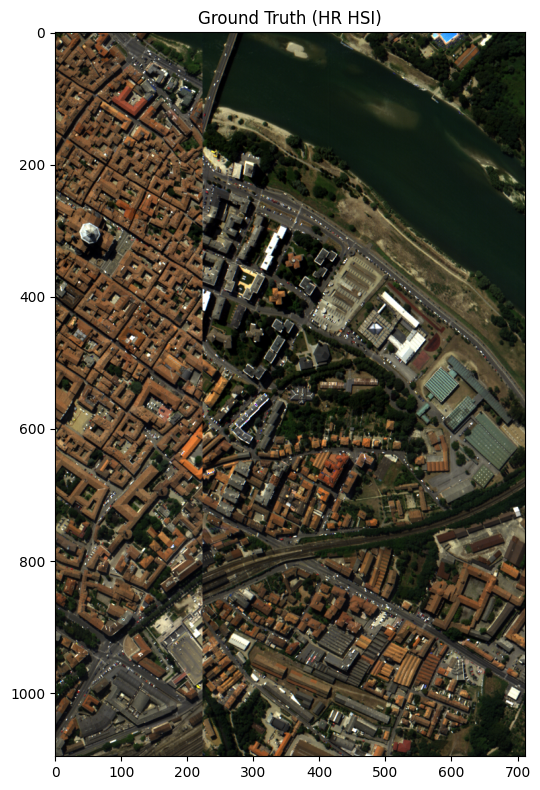

MSI shape:  (1096, 712, 3)


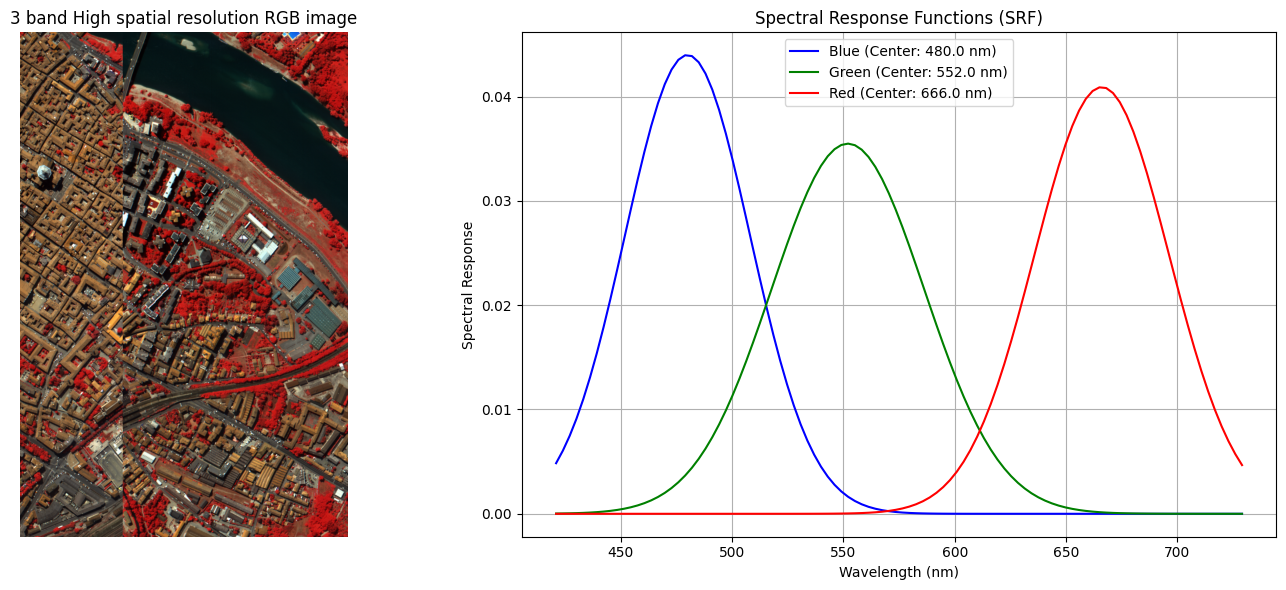

HSI shape with 8x Downsample:  (137, 89, 50)


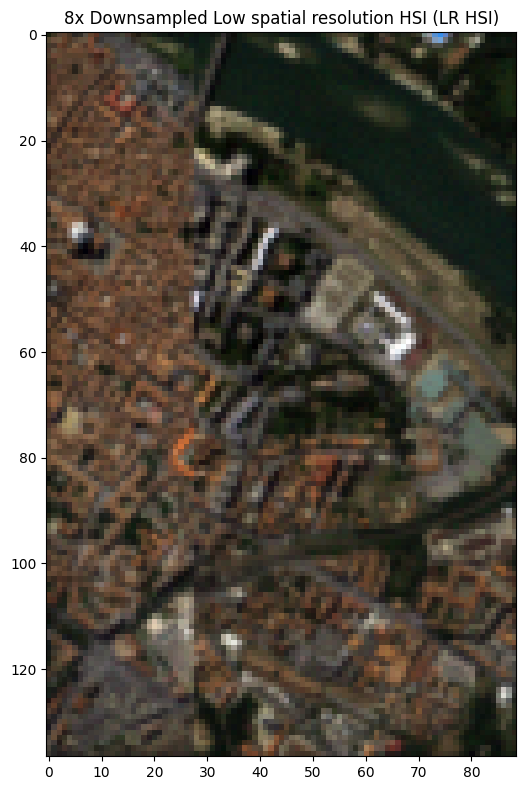

In [15]:
pavia_center = sio.loadmat(mat_file_path)
pavia_center_image = pavia_center['pavia']
pavia_center_image = pavia_center_image[:, :712, :]

# Select 50 uniformly spaced bands
selected_band_idxs = np.linspace(0, 101, 50, dtype=int)

# Ground Truth HR HSI (H, W, C)
I_REF = normalize(pavia_center_image)
# Downsampling spectrally from 102 to 50 bands to make the training as close as possible to inference
I_REF = I_REF[:, :, selected_band_idxs]
print("Ground truth image shape: ", I_REF.shape)
visualize_hsi_single(I_REF, (25,17,7), "Ground Truth (HR HSI)")

# High Resolution MSI with 3 bands
I_MS_3, srf_3, band_specs_3, auto_wavs_3 = spectral_degradation(image=pavia_center_image, SNR=40, num_bands=3, fwhm_factor=4.2)
print("MSI shape: ", I_MS_3.shape)
plot_multispectral_with_srf(I_MS_3, (2,1,0), "3 band High spatial resolution RGB image", srf_3, auto_wavs_3, band_specs_3)

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gaus = spatial_degradation(pavia_center_image, gaus_psf, 8, 30)
# Downsampling spectrally from 102 to 50 bands to make the training as close as possible to inference
I_HS_8_gaus = I_HS_8_gaus[:, :, selected_band_idxs]
print("HSI shape with 8x Downsample: ", I_HS_8_gaus.shape)
visualize_hsi_single(I_HS_8_gaus, (25,17,7), "8x Downsampled Low spatial resolution HSI (LR HSI)")

UH Hyperspectral image 1 inference shape:  (64, 64, 50)
UH Hyperspectral image 2 inference shape:  (64, 64, 50)


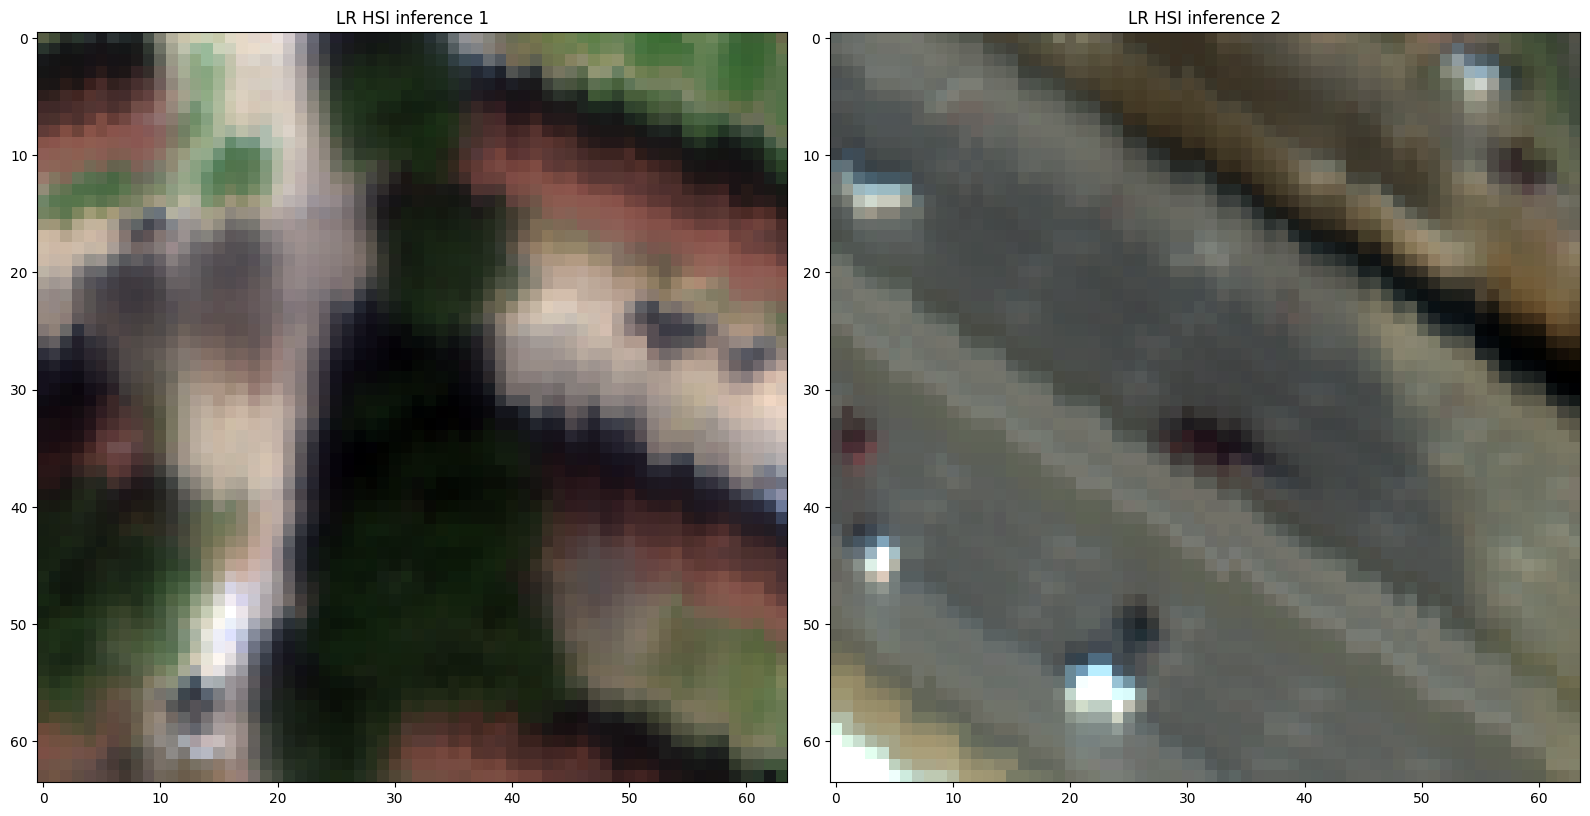

In [16]:
LR_HSI_test_1 = hsi_1_test
print("UH Hyperspectral image 1 inference shape: ", LR_HSI_test_1.shape)

LR_HSI_test_2 = hsi_2_test
print("UH Hyperspectral image 2 inference shape: ", LR_HSI_test_2.shape)

visualize_hsi(LR_HSI_test_1, LR_HSI_test_2, (20,13,8), "LR HSI inference 1", "LR HSI inference 2")

UH RGB image 1 inference shape:  (512, 512, 3)
UH RGB image 2 inference shape:  (512, 512, 3)


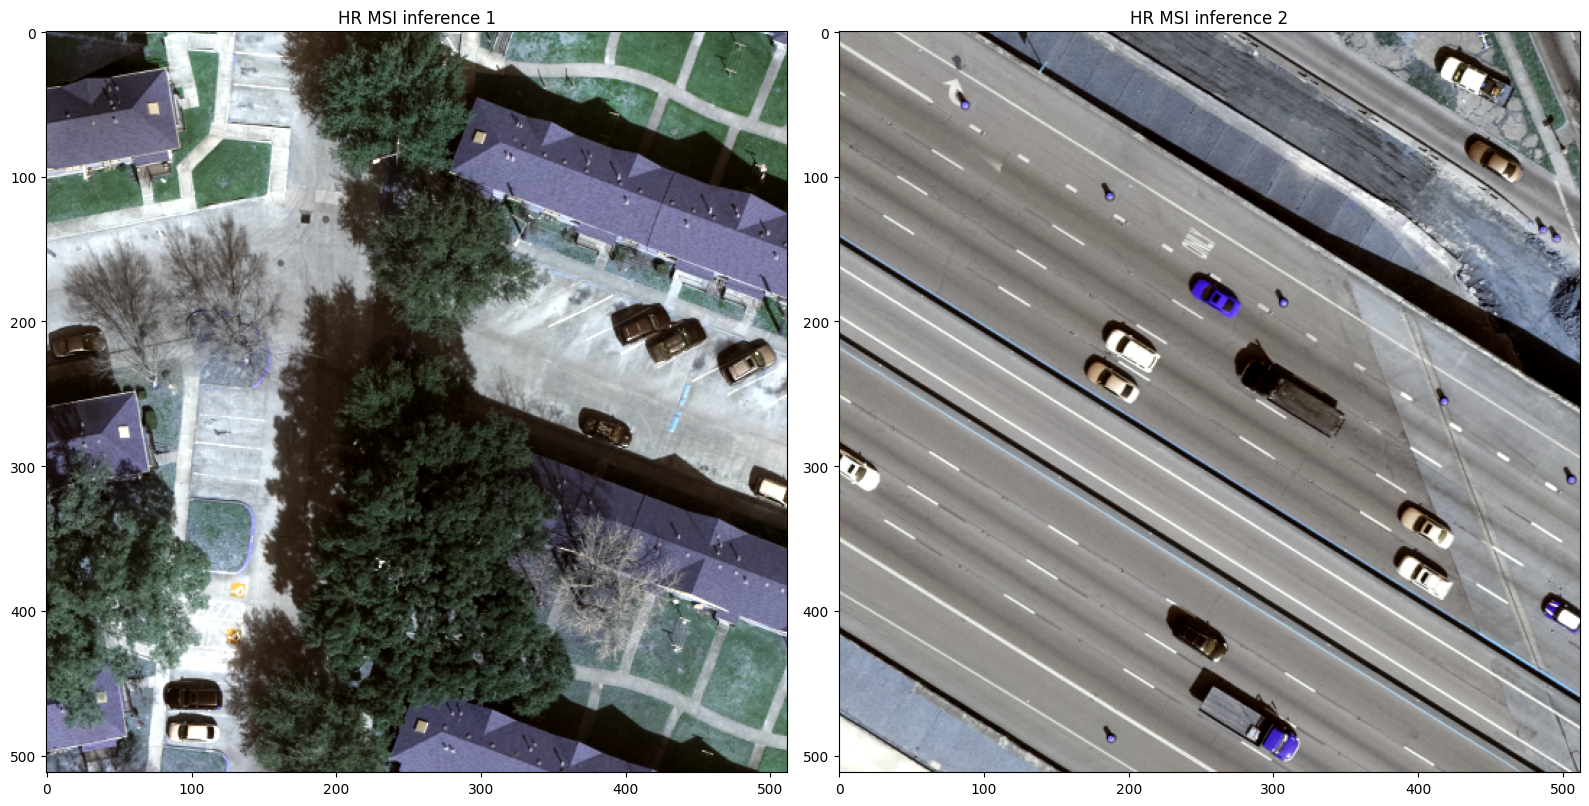

In [17]:
HR_MSI_test_1 = RGB_1_test
print("UH RGB image 1 inference shape: ", HR_MSI_test_1.shape)

HR_MSI_test_2 = RGB_2_test
print("UH RGB image 2 inference shape: ", HR_MSI_test_2.shape)

visualize_hsi(HR_MSI_test_1, HR_MSI_test_2, (0,1,2), "HR MSI inference 1", "HR MSI inference 2")

GuidedNet: A General CNN Fusion Framework via High-Resolution Guidance for Hyperspectral Image Super-Resolution implementation from their GitHub

In [18]:
def get_gpu_memory_mb():
    """Returns current GPU memory usage (in MB) for GPU:0 using TensorFlow."""
    mem_info = tf.config.experimental.get_memory_info('GPU:0')
    return mem_info['current'] / (1024 ** 2)  # bytes → MB

In [19]:
def analyze_model_performance_tf(model, sample_inputs):
    """
    Analyze TensorFlow model performance and print:
    - Number of parameters
    - FLOPs
    - GPU memory consumed (in MB)
    - Inference time (in seconds)

    Parameters:
    -----------
    model : tf.keras.Model
        Your model.

    sample_inputs : list of tf.Tensor
        Input tensors to run inference.
    """

    # --- Infer input_signature from sample_inputs ---
    input_signature = [
        tf.TensorSpec(shape=inp.shape, dtype=inp.dtype) for inp in sample_inputs
    ]

    # --- FLOPs ---
    concrete_func = tf.function(model).get_concrete_function(*input_signature)
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    # Suppress stdout temporarily to hide profiler spam
    original_stdout = sys.stdout
    sys.stdout = iot.StringIO()

    try:
        with tf.Graph().as_default() as graph:
            tf.compat.v1.import_graph_def(graph_def, name='')
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            opts['output'] = 'none'

            flops = tf.compat.v1.profiler.profile(
                graph=graph,
                run_meta=run_meta,
                options=opts
            ).total_float_ops
    finally:
        sys.stdout = original_stdout

    # --- Parameters ---
    num_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
    start_mem = get_gpu_memory_mb()

    # --- Inference Time ---
    start = time.time()
    _ = model(*sample_inputs, training=False)
    end = time.time()
    inference_time_sec = end - start

    # --- GPU Memory consumed at inference---
    end_mem = get_gpu_memory_mb()
    mem_used = end_mem - start_mem

    # --- Print Results ---
    print(f"Number of parameters: {num_params:,}")
    print(f"FLOPs: {flops:,}")
    print(f"GPU Memory:      {mem_used:.2f} MB")
    print(f"Inference time: {inference_time_sec:.4f} seconds")

In [20]:
def make_patches_tf(hr_hsi, hr_msi, lr_hsi,
                    patch_hr=32, scale=8, stride_hr=256):
    """
    Inputs:
        hr_hsi: Tensor of shape (H, W, C_hsi)
        hr_msi: Tensor of shape (H, W, C_msi)
        lr_hsi: Tensor of shape (H/scale, W/scale, C_hsi)
    
    Returns:
        HR_MSI, LR_HSI, HR_HSI as tf.Tensor with shape (N, H, W, C)
    """
    stride_lr = stride_hr // scale
    patch_lr = patch_hr // scale

    def extract_patches(img, patch_size, stride):
        # Add batch dimension
        img = tf.expand_dims(img, axis=0)  # (1, H, W, C)
        patches = tf.image.extract_patches(
            images=img,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, stride, stride, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        # Reshape to (N, patch_size, patch_size, C)
        patch_shape = tf.shape(patches)
        patch_H = patch_shape[1]
        patch_W = patch_shape[2]
        C = tf.shape(img)[-1]
        patches = tf.reshape(patches, (patch_H * patch_W, patch_size, patch_size, C))
        return patches

    HR_HSI = extract_patches(hr_hsi, patch_hr, stride_hr)
    HR_MSI = extract_patches(hr_msi, patch_hr, stride_hr)
    LR_HSI = extract_patches(lr_hsi, patch_lr, stride_lr)

    return HR_MSI, LR_HSI, HR_HSI

class PatchDatasetTF(tf.data.Dataset):
    @staticmethod
    def _generator(msi, lr, gt):
        for i in range(msi.shape[0]):
            yield msi[i], lr[i], gt[i]

    def __new__(cls, msi, lr, gt):
        # Ensure tensors are tf.Tensor and in float32
        msi = tf.convert_to_tensor(msi, dtype=tf.float32)
        lr  = tf.convert_to_tensor(lr,  dtype=tf.float32)
        gt  = tf.convert_to_tensor(gt,  dtype=tf.float32)

        # Define the shape of each element (not batch)
        output_signature = (
            tf.TensorSpec(shape=msi.shape[1:], dtype=tf.float32),
            tf.TensorSpec(shape=lr.shape[1:],  dtype=tf.float32),
            tf.TensorSpec(shape=gt.shape[1:],  dtype=tf.float32),
        )

        return tf.data.Dataset.from_generator(
            lambda: cls._generator(msi, lr, gt),
            output_signature=output_signature
        )

In [21]:
class Subpixel2D(tf.keras.layers.Layer):
    """
    Subpixel upsampling using tf.nn.depth_to_space.
    Expects last dimension = (channels * (block_size^2)).
    """
    def __init__(self, block_size=2, **kwargs):
        super().__init__(**kwargs)
        self.block_size = block_size

    def call(self, inputs):
        # inputs: (batch, h, w, c * block_size^2)
        return tf.nn.depth_to_space(inputs, self.block_size)


class HyNetSingleLevel(tf.keras.layers.Layer):
    """
    One scale level: upsamples net_feature by 2×, merges with MSI,
    does residual blocks, then upsamples net_image by 2× + gradient correction.
    """
    def __init__(self, hs_bands=31, res_number=10, **kwargs):
        super().__init__(**kwargs)
        self.hs_bands = hs_bands
        self.res_number = res_number

        # Feature upsampling (Conv2DTranspose with stride=2)
        self.deconv_feature = tf.keras.layers.Conv2DTranspose(
            filters=64, kernel_size=6, strides=2, padding='same',
            kernel_initializer=tf.keras.initializers.GlorotUniform()
        )

        # Merge Convs after concat
        self.merge_conv1 = tf.keras.layers.Conv2D(
            filters=64, kernel_size=3, padding='same',
            kernel_initializer=tf.keras.initializers.GlorotUniform()
        )
        self.merge_conv2 = tf.keras.layers.Conv2D(
            filters=64, kernel_size=3, padding='same',
            kernel_initializer=tf.keras.initializers.GlorotUniform()
        )

        # Residual blocks
        self.residual_convs = []
        for _ in range(res_number):
            conv = tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, padding='same',
                kernel_initializer=tf.keras.initializers.GlorotUniform()
            )
            self.residual_convs.append(conv)

        # Gradient conv => produce "hs_bands" channels
        self.gradient_conv = tf.keras.layers.Conv2D(
            filters=self.hs_bands, kernel_size=3, padding='same',
            kernel_initializer=tf.keras.initializers.GlorotUniform()
        )

        # Upsample net_image => use subpixel
        self.upconv_image = tf.keras.layers.Conv2D(
            filters=self.hs_bands * 4,  # subpixel x2 => *4
            kernel_size=3, padding='same',
            kernel_initializer=tf.keras.initializers.GlorotUniform()
        )
        self.subpixel_image = Subpixel2D(block_size=2)

    def call(self, net_image, net_feature, msi_downsample, training=None):
        """
        net_image:   (B, h, w, hs_bands)
        net_feature: (B, h, w, 64)
        msi_downsample: (B, h, w, ???)  # MSI at same scale as net_feature
        """
        # 1) Upsample net_feature by 2×
        net_feature_up = self.deconv_feature(net_feature, training=training)
        # 2) Concatenate with MSI
        concat = tf.concat([net_feature_up, msi_downsample], axis=-1)
        # 3) Merge conv
        x = self.merge_conv1(concat, training=training)
        x = self.merge_conv2(x, training=training)
        # 4) Residual blocks
        for conv in self.residual_convs:
            tmp = tf.nn.leaky_relu(x)
            tmp = conv(tmp, training=training)
            x = x + tmp
        net_feature_out = x

        # 5) Gradient in HSI domain
        gradient_level = self.gradient_conv(x, training=training)

        # 6) Upsample net_image by 2 using subpixel
        net_image_conv = self.upconv_image(net_image, training=training)
        net_image_up = self.subpixel_image(net_image_conv)

        # 7) Add gradient
        net_image_up = net_image_up + gradient_level

        return net_image_up, net_feature_out


class MultiScaleHyNet(tf.keras.Model):
    def __init__(self, hs_bands=31, msi_channels=4, res_number=10, scale_factor=8):
        super().__init__()
        self.num_levels = int(math.log2(scale_factor))

        # Initial convs
        self.init_conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')
        self.init_conv2 = tf.keras.layers.Conv2D(64, 3, padding='same')

        # HyNetSingleLevel blocks
        self.levels = []
        for _ in range(self.num_levels):
            self.levels.append(HyNetSingleLevel(hs_bands=hs_bands, res_number=res_number))

        # Downsamplers
        self.msi_downs = []
        for _ in range(self.num_levels):
            self.msi_downs.append(
                tf.keras.layers.Conv2D(msi_channels, 6, strides=2, padding='same')
            )

    def call(self, lr_hsi, hr_msi, training=None):
        # 1) Feature extraction
        net_feature = self.init_conv1(lr_hsi, training=training)
        net_feature = self.init_conv2(net_feature, training=training)
        net_image   = lr_hsi

        # 2) We store [8×, 4×, 2×, 1×] in msi_scales if scale_factor=8
        msi_scales = [hr_msi]
        temp = hr_msi
        for down in self.msi_downs: 
            temp = down(temp, training=training)
            msi_scales.append(temp)

        # Reverse them so now we have [1×, 2×, 4×, 8×]
        msi_scales.reverse()

        # 3) Now do each level:
        #    First level => up from 1× to 2× => feed the 2× MSI,
        #    second => from 2× to 4× => feed the 4× MSI, etc.
        outputs = []
        for i, level in enumerate(self.levels):
            # i=0 => net_image is 1× => after the block => 2×
            # we want msi_scales[1], which is 2×
            msi_for_level = msi_scales[i+1]
            net_image, net_feature = level(net_image, net_feature, msi_for_level, training=training)
            outputs.append(net_image)

        return outputs

In [22]:
def extract_patch_at_coordinates(image, top_y, left_x, patch_size=16):
    """
    Extract a patch of size patch_size x patch_size starting at (top_y, left_x).

    Args:
        image (np.ndarray): Image of shape (H, W, C).
        top_y (int): Y-coordinate (row) of the top-left corner of the patch.
        left_x (int): X-coordinate (column) of the top-left corner of the patch.
        patch_size (int): Size of the patch (default: 16).

    Returns:
        patch (np.ndarray): Extracted patch of shape (patch_size, patch_size, C).
    """
    # Bounds check
    if (top_y < 0 or left_x < 0 or
        top_y + patch_size > image.shape[0] or
        left_x + patch_size > image.shape[1]):
        raise ValueError("Patch goes out of image bounds.")

    return image[top_y : top_y + patch_size, left_x : left_x + patch_size, :]

Output file to save super-resolved images

In [23]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the target directory
target_relative_path = "../../../Super_Resolved_Images_From_Comparison_Implementations/GuidedNet"

# Construct the full path to the target directory
target_path = os.path.join(notebook_directory, target_relative_path)

# Normalize the path to remove redundancies
normalized_target_path = os.path.normpath(target_path)

# Define the path to the folder
uh_guidednet_folder_path = os.path.join(normalized_target_path, 'University_of_Houston')

# Create the folder if it doesn't exist
if not os.path.exists(uh_guidednet_folder_path):
    os.makedirs(uh_guidednet_folder_path)

Super resolving UH image 1 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006894834..0.99999905].


MSI patch tensor shape:  (3, 512, 512, 3)
LR HSI patch tensor shape:  (3, 64, 64, 50)
GT HR HSI patch tensor shape:  (3, 512, 512, 50)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012886192..0.99999905].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008092889..0.99999905].


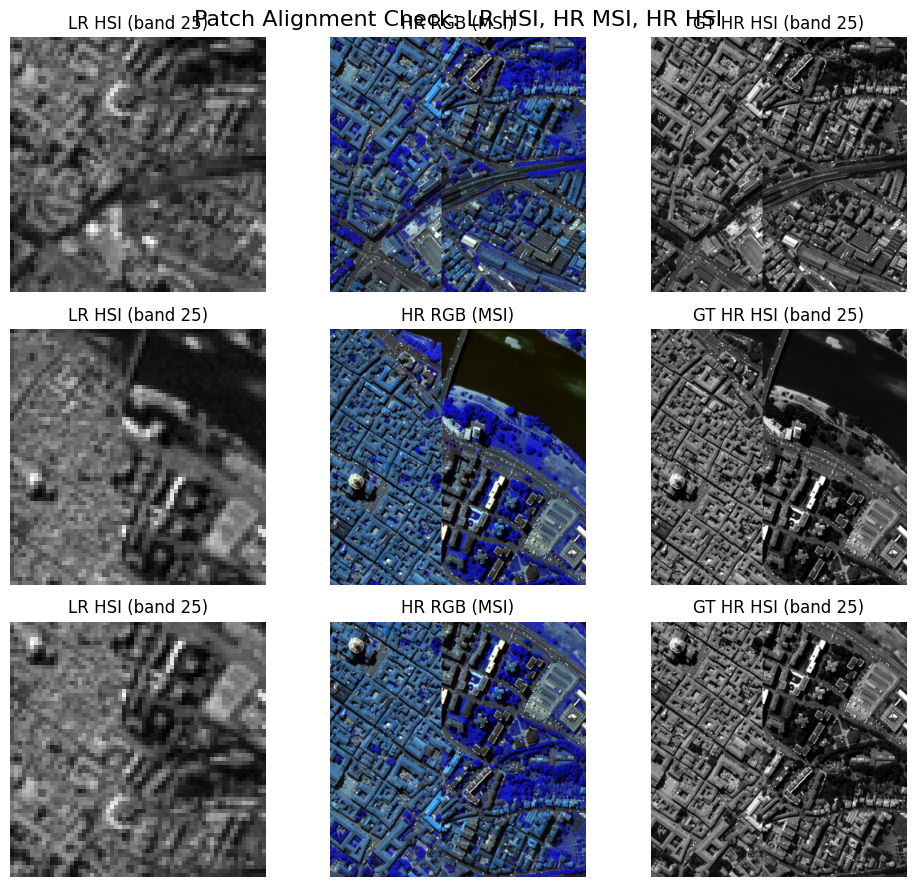

Starting patch-based training...


Training:   0%|                                                         | 0/5000 [00:00<?, ?epoch/s]/home/rgshah_umass_edu/miniconda3/envs/spectralift/lib/python3.9/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['multi_scale_hy_net/conv2d_46/kernel', 'multi_scale_hy_net/conv2d_46/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
W0000 00:00:1752343075.684508  643464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752343075.734025  643463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752343075.800501  643463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752343076.644700  643463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752343076.651308  643463 gpu_timer.cc:114

Training completed in 1296.36 seconds


W0000 00:00:1752344360.806525  643416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752344360.811216  643416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752344360.815032  643416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752344360.820292  643416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752344360.825482  643416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752344360.842344  643416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752344360.847383  643416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
I0000 00:00:1752344361.189635  643416 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Number of parameters: 2,201,075
FLOPs: 367,412,854,784
GPU Memory:      65.62 MB
Inference time: 0.0594 seconds
SR image shape:  (512, 512, 50)
SR image max: 1.2596912
SR image min: -0.22359903
SR image mean: 0.3865241
Saved Super Resolved HSI 1 at location specified in uh_guidednet_folder_path


In [24]:
# Extract patches from the synthetic Pavia Center data
msi_train, hsi_train, gt_train = make_patches_tf(
    hr_hsi=I_REF,           # Ground truth HR HSI (normalized, 50 bands)
    hr_msi=I_MS_3,          # HR MSI image (3 bands)
    lr_hsi=I_HS_8_gaus,     # LR HSI (downsampled, normalized, 50 bands)
    patch_hr=512,
    scale=8,
    stride_hr=256
)

gt_train  = tf.cast(gt_train, dtype=tf.float32)
msi_train = tf.cast(msi_train, dtype=tf.float32)
hsi_train = tf.cast(hsi_train, dtype=tf.float32)

# Confirm the shape of patches
print("MSI patch tensor shape: ", msi_train.shape)
print("LR HSI patch tensor shape: ", hsi_train.shape)
print("GT HR HSI patch tensor shape: ", gt_train.shape)

# Visualize a few patch triplets
plot_alignment_grid_np(hsi_train.numpy(), msi_train.numpy(), gt_train.numpy(),
                       band_lr=25, band_hr=25)

# Create the dataset using your custom wrapper
train_dataset = PatchDatasetTF(msi_train, hsi_train, gt_train)

# Then wrap it into a loader just like PyTorch's DataLoader
train_loader = train_dataset.shuffle(buffer_size=len(msi_train)) \
                            .batch(16, drop_remainder=False) \
                            .prefetch(tf.data.AUTOTUNE)

# Initializing the model
# Hyperparameters
EPOCHS       = 5000  # Instead of iterations (we'll use batch loop)
BATCH_SIZE   = 16
lr_rate      = 1e-4
res_number   = 10
alpha        = [1, 2, 4]  # multi-scale loss weights
loss_history = []

# Model init
HS_bands = hsi_train.shape[-1]
msi_ch   = msi_train.shape[-1]

model = MultiScaleHyNet(
    hs_bands=HS_bands,
    msi_channels=msi_ch,
    res_number=res_number,
    scale_factor=8
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate)

@tf.function
def train_step(lr_hsi, hr_msi, gt_hsi):
    with tf.GradientTape() as tape:
        net_image2x, net_image4x, net_image8x = model(lr_hsi, hr_msi, training=True)

        # Resize GT for multi-scale supervision
        gt_4x = tf.image.resize(gt_hsi, [gt_hsi.shape[1] // 2, gt_hsi.shape[2] // 2], method='nearest')
        gt_2x = tf.image.resize(gt_hsi, [gt_hsi.shape[1] // 4, gt_hsi.shape[2] // 4], method='nearest')

        # L1 loss at each scale
        loss_8x = tf.reduce_mean(tf.abs(net_image8x - gt_hsi))
        loss_4x = tf.reduce_mean(tf.abs(net_image4x - gt_4x))
        loss_2x = tf.reduce_mean(tf.abs(net_image2x - gt_2x))

        # Weighted loss
        total_loss = alpha[0]*loss_2x + alpha[1]*loss_4x + alpha[2]*loss_8x

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss

print("Starting patch-based training...")

start_time = time.perf_counter()

pbar = tqdm(range(EPOCHS), desc="Training", unit="epoch", ncols=100)

for epoch in pbar:
    epoch_losses = []

    for msi_batch, lr_hsi_batch, gt_hsi_batch in train_loader:
        loss = train_step(lr_hsi_batch, msi_batch, gt_hsi_batch)
        epoch_losses.append(loss.numpy())

    avg_loss = np.mean(epoch_losses)
    loss_history.append(avg_loss)

    pbar.set_postfix({
        "avg_loss": f"{avg_loss:.4e}"
    })

end_time = time.perf_counter()
print(f"Training completed in {end_time - start_time:.2f} seconds")

# Defining the inputs for inference
HSI_test = numpy_to_tf(LR_HSI_test_1)
MSI_test = numpy_to_tf(HR_MSI_test_1)

# Running inference
net_images_test = model(HSI_test, MSI_test, training=False)
# net_images_test[2] is the final 8× output (if scale_factor=8)
net_image1_test = net_images_test[0]  # 2×
net_image2_test = net_images_test[1]  # 4×
net_image3_test = net_images_test[2]  # 8×

SR_image_1 = tf_to_numpy(net_image3_test)  # Convert final SR (8×) to NumPy if needed

# Measuring and printing metrics
sample_inputs = [HSI_test, MSI_test]
analyze_model_performance_tf(model, sample_inputs)

print("SR image shape: ", SR_image_1.shape)
print("SR image max:", SR_image_1.max())
print("SR image min:", SR_image_1.min())
print("SR image mean:", SR_image_1.mean())

# Full file path (including the file name and extension)
file_path = f"{uh_guidednet_folder_path}/UH_topleft.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image_1)

print("Saved Super Resolved HSI 1 at location specified in uh_guidednet_folder_path")

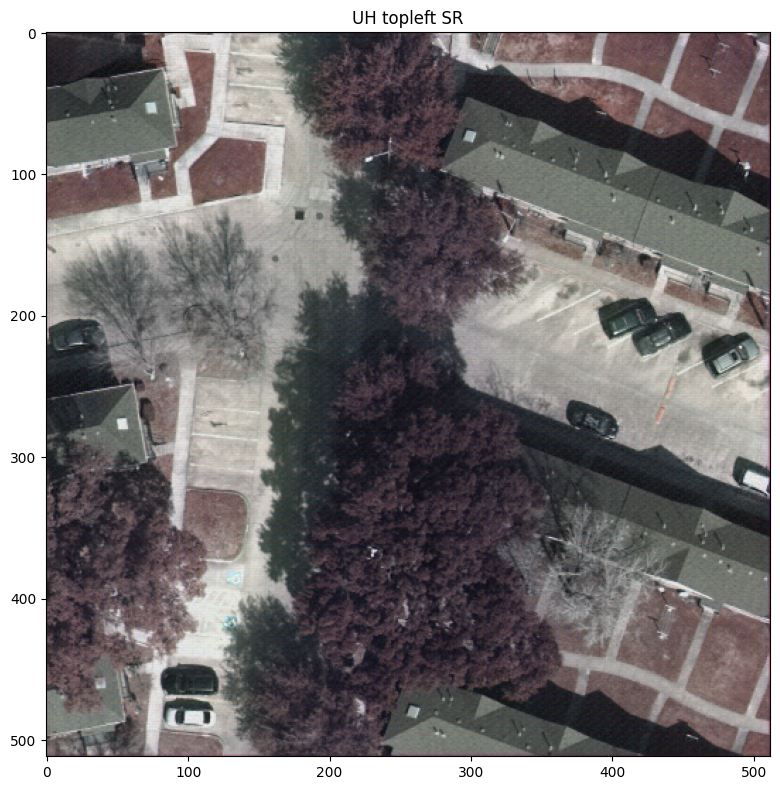

In [25]:
visualize_hsi_single(SR_image_1, (20,13,8), "UH topleft SR")

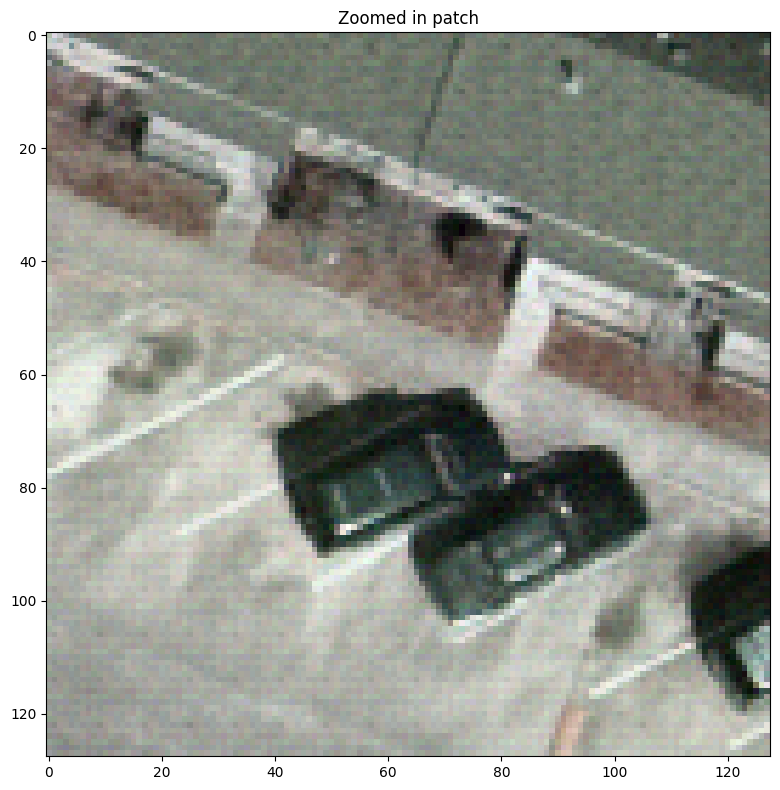

In [26]:
patch = extract_patch_at_coordinates(SR_image_1, 125, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")

Super resolving UH image 2

In [27]:
# Defining the inputs for inference
HSI_test = numpy_to_tf(LR_HSI_test_2)
MSI_test = numpy_to_tf(HR_MSI_test_2)

# Running inference
net_images_test = model(HSI_test, MSI_test, training=False)
# net_images_test[2] is the final 8× output (if scale_factor=8)
net_image1_test = net_images_test[0]  # 2×
net_image2_test = net_images_test[1]  # 4×
net_image3_test = net_images_test[2]  # 8×

SR_image_2 = tf_to_numpy(net_image3_test)  # Convert final SR (8×) to NumPy if needed

# Measuring and printing metrics
sample_inputs = [HSI_test, MSI_test]
analyze_model_performance_tf(model, sample_inputs)

print("SR image shape: ", SR_image_2.shape)
print("SR image max:", SR_image_2.max())
print("SR image min:", SR_image_2.min())
print("SR image mean:", SR_image_2.mean())

# Full file path (including the file name and extension)
file_path = f"{uh_guidednet_folder_path}/UH_bottomright.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image_2)

print("Saved Super Resolved HSI 2 at location specified in uh_guidednet_folder_path")

I0000 00:00:1752344362.887462  643416 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1


Number of parameters: 2,201,075
FLOPs: 367,412,854,784
GPU Memory:      65.62 MB
Inference time: 0.0593 seconds
SR image shape:  (512, 512, 50)
SR image max: 1.4203448
SR image min: -0.33399832
SR image mean: 0.50630265
Saved Super Resolved HSI 2 at location specified in uh_guidednet_folder_path


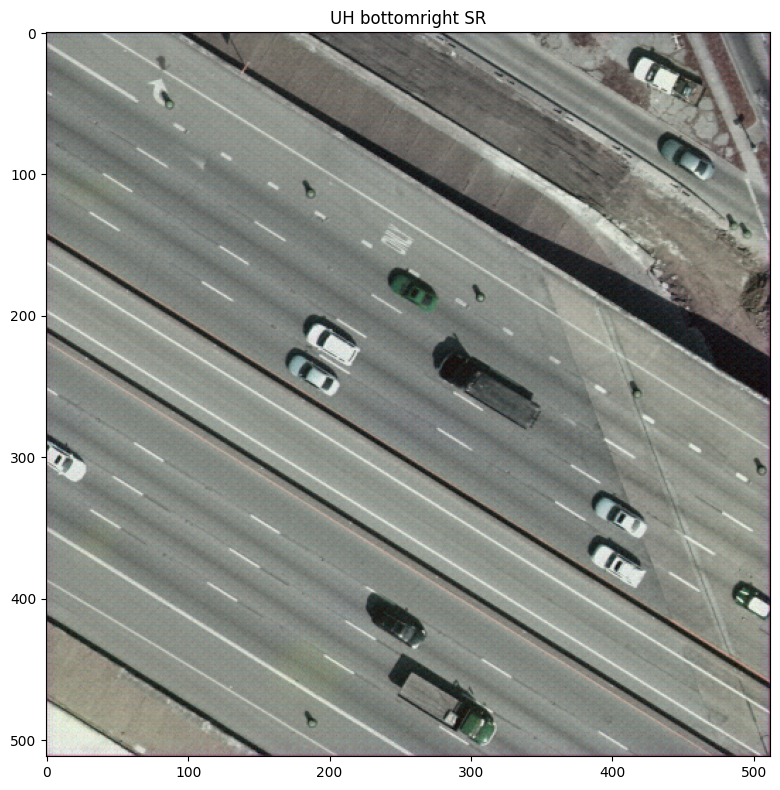

In [28]:
visualize_hsi_single(SR_image_2, (20,13,8), "UH bottomright SR")

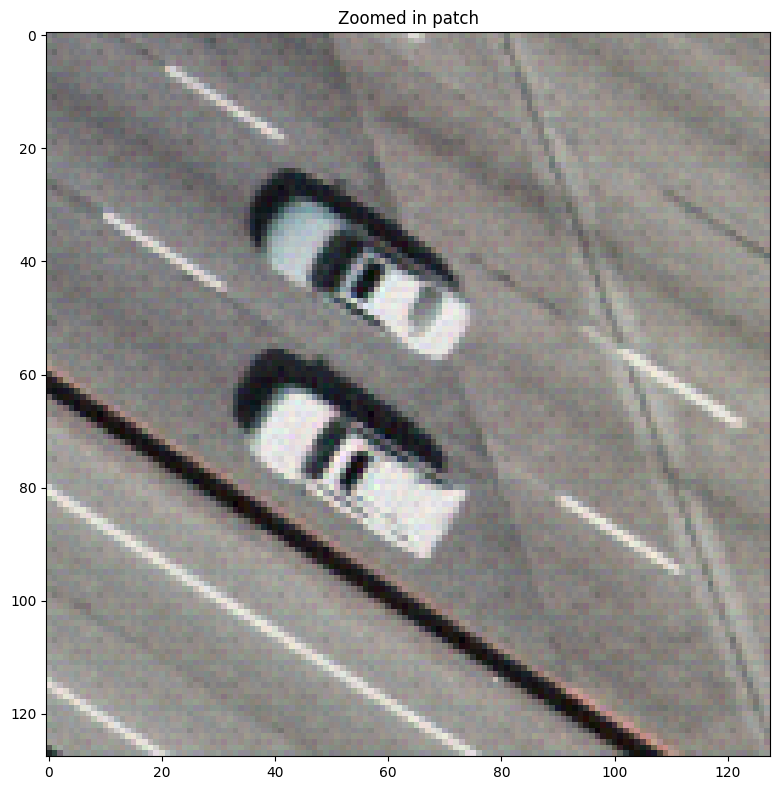

In [29]:
patch = extract_patch_at_coordinates(SR_image_2, 300, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")